<a href="https://colab.research.google.com/github/jhou27/NLP_with_Python/blob/main/NER_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

data = pd.read_csv('/content/drive/My Drive/coding/data/ner_datasetreference.csv', encoding= 'unicode_escape')
print(data.shape)
data.head()

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


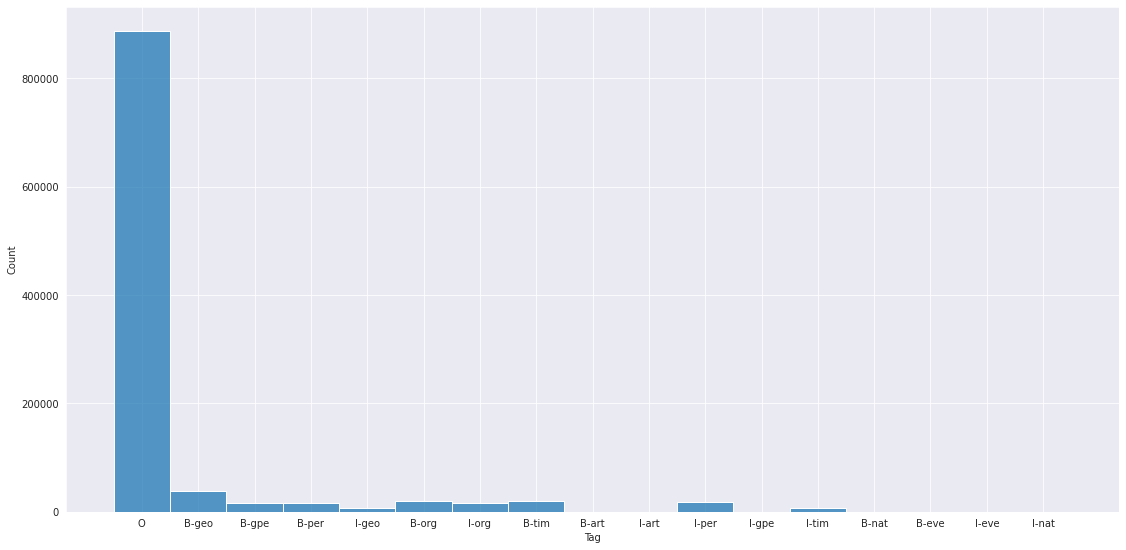

In [2]:
#tag distribution
plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(data['Tag'])
plt.tight_layout(pad=2)
plt.show()

#Data preprocessing

In [3]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')


In [4]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

In [5]:
data_group

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[17445, 9757, 26556, 21192, 3603, 27030, 9867,...","[6, 6, 6, 6, 6, 6, 15, 6, 6, 6, 6, 6, 15, 6, 6..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[34485, 11618, 29080, 34771, 26953, 27567, 218...","[0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[15368, 27581, 15670, 6595, 762, 15777, 13065,...","[6, 6, 10, 6, 6, 6, 6, 6, 15, 6, 6, 6, 6, 6, 9..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[3508, 31090, 21546, 6189, 27397, 5932, 8927, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[22793, 23746, 27, 24669, 7191, 33179, 29091, ...","[15, 6, 6, 7, 16, 6, 10, 6, 15, 6, 0, 6, 0, 6,..."
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[22487, 30836, 29643, 9461, 4642, 10746, 33179...","[6, 6, 6, 7, 16, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[16618, 19758, 6953, 34485, 7396, 6940, 9386, ...","[6, 10, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 9, 14, 6..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[18285, 16949, 18075, 13792, 24126, 26603, 159...","[6, 15, 6, 6, 10, 13, 6, 6, 6, 6, 6, 6, 6, 6, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[15009, 33229, 6953, 22794, 21192, 23674, 9541...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."


In [6]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'val_tags: ',val_tags.shape,'test_tags: ',test_tags.shape)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791
train_tags:  (32372, 104, 17) val_tags:  (10791, 104, 17) test_tags:  (4796, 104, 17)


#Building model & training

In [7]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [8]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [9]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [10]:
train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

(32372, 104)
(32372, 104)


In [11]:
nlp_model = get_bilstm_lstm_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2) 
#tf.keras.models.save_model(nlp_model, filepath  = "./nlp_model.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           49408     
                                                                 
 dense (Dense)               (None, 104, 17)           1105      
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
405/405 [==============================] - 504s 1s/step - loss: 0.2082 - accuracy: 0.9654 - val_loss: 

In [12]:
y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(4796, 104) (4796, 104)
150/150 [==============================] - 12s 80ms/step - loss: 0.0341 - accuracy: 0.9909


[0.03408830612897873, 0.9909179210662842]

In [13]:
y_test2 = np.argmax(val_tags, axis=-1)
print(test_tokens.shape,y_test2.shape)
nlp_model.evaluate(val_tokens, y_test2)

(4796, 104) (10791, 104)
338/338 [==============================] - 31s 92ms/step - loss: 0.0343 - accuracy: 0.9907


[0.034317344427108765, 0.990717887878418]

In [15]:
def predict(seed):
    query  = test_tokens[seed]
    query_text = []
    for i in query.tolist():
        query_text.append(idx2token.get(i))
    print('Query_Text: ',' '.join(query_text[:10]))

    ans = y_test[seed]
    ans_text = []
    for i in ans.tolist():
        ans_text.append(idx2tag.get(i))
    print('Tag_Text: ',' '.join(ans_text[:10]))

    query = query.reshape(1,-1)
    pred = nlp_model.predict(query)
    pred = np.ravel(np.argmax(pred, axis=-1))
    print('Query: ',query.shape,'Prediction: ',pred.shape)

    pred_list = []
    for i in pred.tolist():
        pred_list.append(idx2tag.get(i))
    print('Prediction_Text: ',' '.join(pred_list[:10])) 
    print()
    print('--- Better-Representation---')
    print()
    rep_qr = []
    for q, r_tag in zip(query_text[:10], ans_text[:10]):
        rep_qr.append(q)
        rep_qr.append('['+r_tag+']')
    print('Actual_NER: ',' '.join(rep_qr),'....')
    print()
    rep_qp = []
    for q, r_tag in zip(query_text[:10], pred_list[:10]):
        rep_qp.append(q)
        rep_qp.append('['+r_tag+']')
    print('--'*70)
    print()
    print('Predicted_NER: ',' '.join(rep_qp),'....')

seed = 10
predict(seed)

Query_Text:  Under the new law , the Kremlin would select gubernatorial
Tag_Text:  O O O O O O B-org O O O
1/1 [==============================] - 0s 87ms/step
Query:  (1, 104) Prediction:  (104,)
Prediction_Text:  O O O O O O B-org O O O

--- Better-Representation---

Actual_NER:  Under [O] the [O] new [O] law [O] , [O] the [O] Kremlin [B-org] would [O] select [O] gubernatorial [O] ....

--------------------------------------------------------------------------------------------------------------------------------------------

Predicted_NER:  Under [O] the [O] new [O] law [O] , [O] the [O] Kremlin [B-org] would [O] select [O] gubernatorial [O] ....


In [17]:
#using spacy to do NER
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Under the new law , the Kremlin would select gubernatorial')
displacy.render(text, style = 'ent', jupyter=True)